# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/sample_submission.csv'))
df_train: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/train.csv'), index_col='id')
df_test: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e16/test.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/crab-age-prediction/CrabAgePrediction.csv'))

In [4]:
df_train.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [5]:
df_test.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

In [6]:
df_og.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

##### No missing value, does not hurt to check

In [7]:
df_sample_submission.head()

,id,Age
0,74051,10
1,74052,10
2,74053,10
3,74054,10
4,74055,10


##### We simple predicting age for each crab

In [8]:
df_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [9]:
df_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
id,,,,,,,,
74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [10]:
df_og.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [11]:
df_train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [12]:
df_test.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


In [13]:
df_og.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


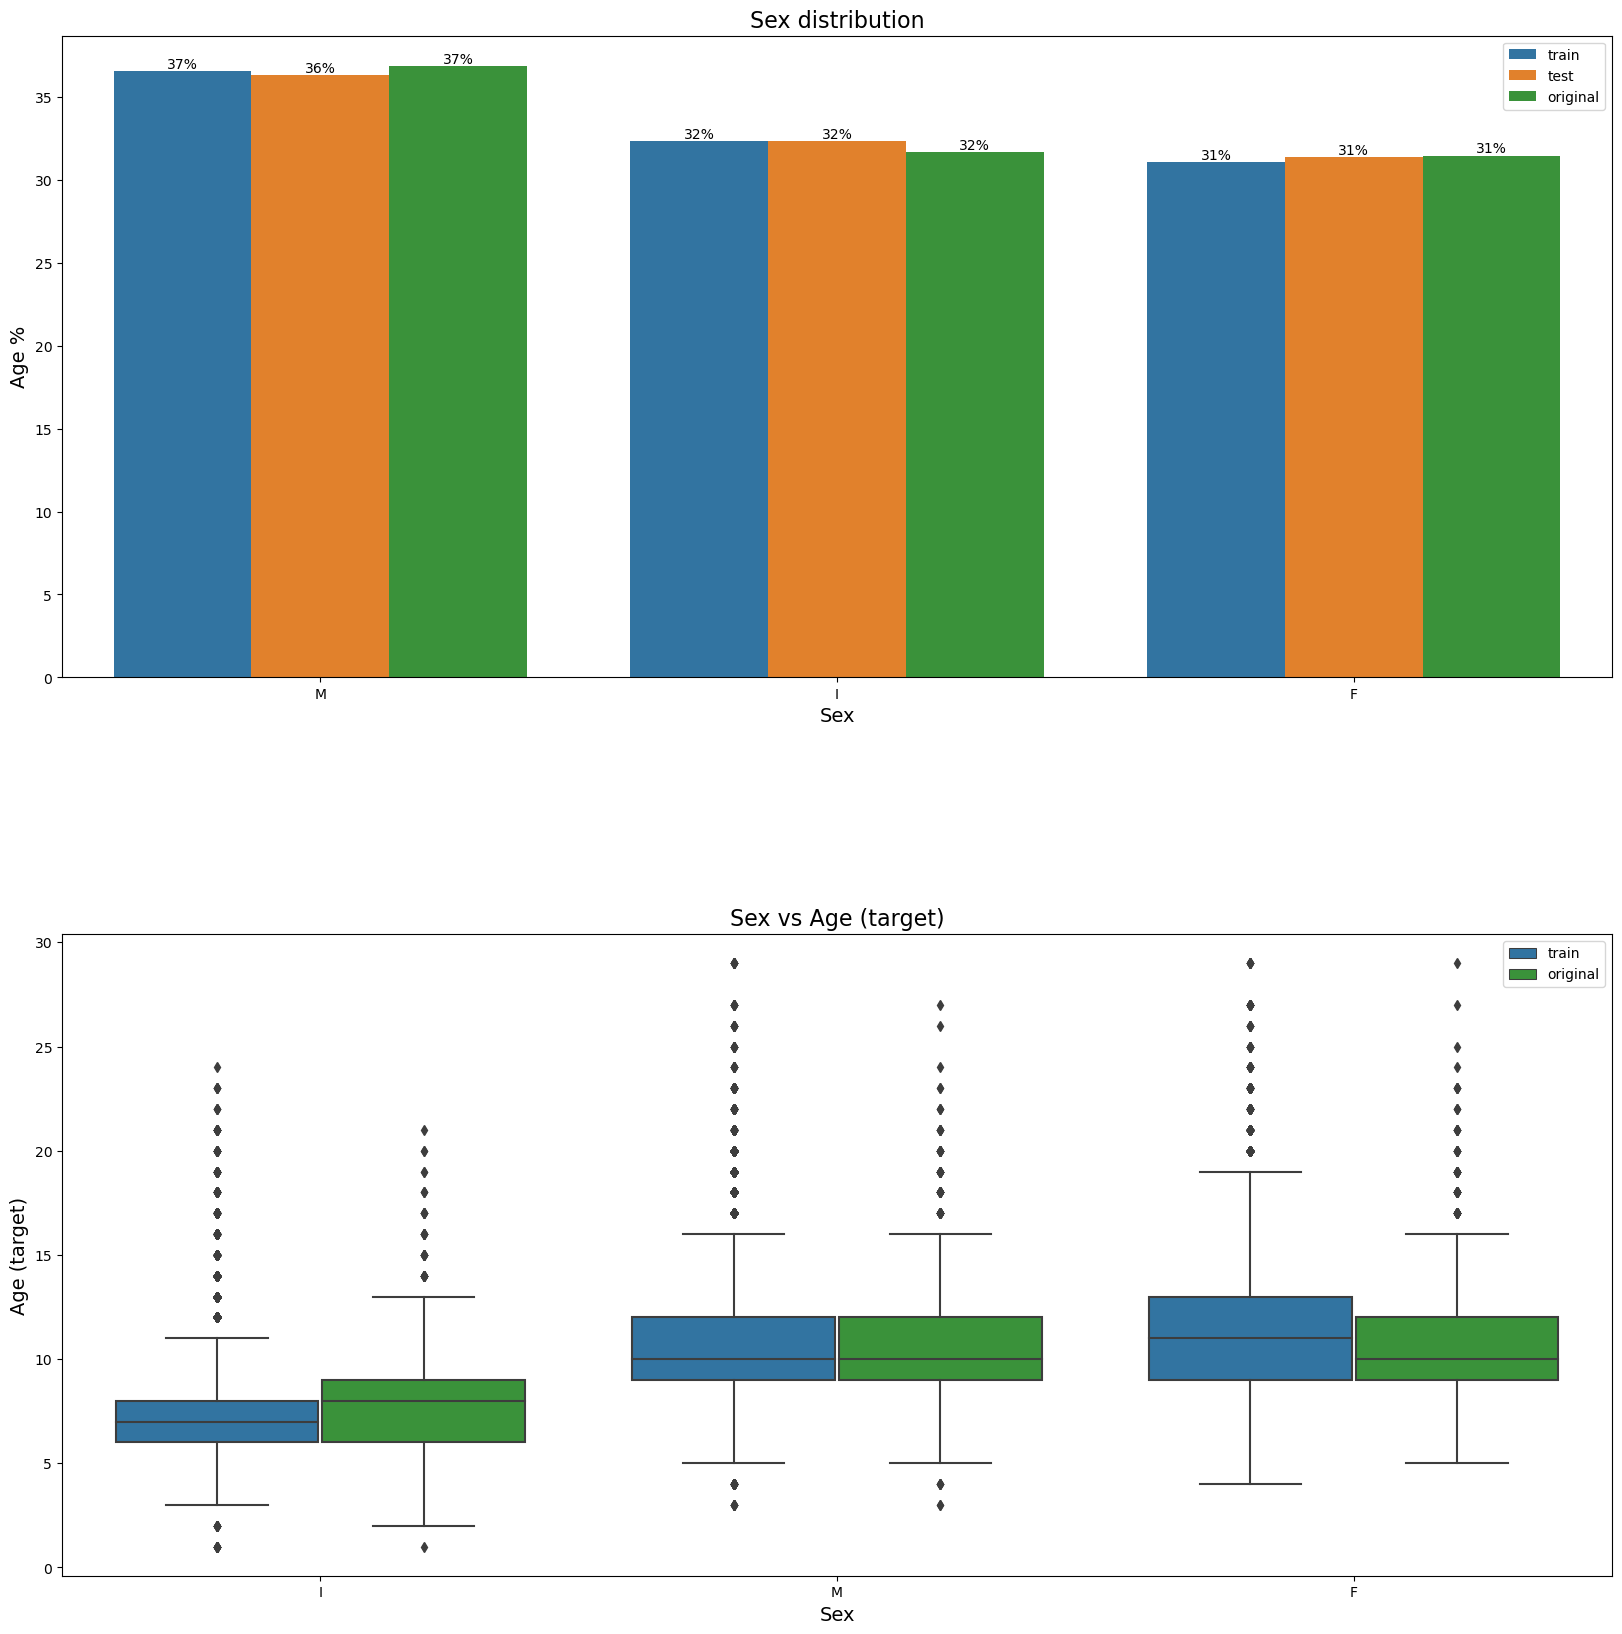

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int,
                              x_label: list[str] = ('x', 'x'), y_label: list[str] = ('y', 'y'), title: list[str]=None, colors: list[str] = None) -> None:

    # Plot barplots
    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        df_tmp_local = pd.DataFrame(df[column].value_counts() * 100 / df[column].count())
        df_tmp_local['dataset'] = label
        df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp['x'] = df_tmp.index
    df_tmp = df_tmp.rename(columns={column: 'y', 'dataset': 'Data Set'})
    sns.barplot(data=df_tmp, y='y', x="x", hue="Data Set", orient='v', ax=axes[axes_start_i])
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f') + '%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 5),
                    textcoords = 'offset points')
    axes[axes_start_i].set_xlabel(x_label[0], fontsize=14)
    axes[axes_start_i].set_ylabel(y_label[0], fontsize=14)
    if title is not None:
        axes[axes_start_i].set_title(title[0], fontsize=16)

    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        if label != 'test':
            df_tmp_local = df.loc[:, [column, target]]
            df_tmp_local['dataset'] = label
            df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)
    df_tmp = df_tmp.rename(columns={column: 'c', 'dataset': 'Data Set'})
    if colors is not None:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1], palette=colors)
    else:
        sns.boxplot(x='c', y=target, data=df_tmp, orient='v', hue="Data Set", ax=axes[axes_start_i + 1])
    axes[axes_start_i + 1].set_xlabel(x_label[1], fontsize=14)
    axes[axes_start_i + 1].set_ylabel(y_label[1], fontsize=14)
    if title is not None:
        axes[axes_start_i + 1].set_title(title[1], fontsize=16)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()

i = 0
graph_categorical_feature([(df_train, 'Sex', 'train'), (df_test, 'Sex', 'test'), (df_og, 'Sex', 'original')], 
                          'Age', i, 
                          x_label=['Sex', 'Sex'], 
                          y_label=['Age %', 'Age (target)'], 
                          title=['Sex distribution', 'Sex vs Age (target)'], 
                          colors=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

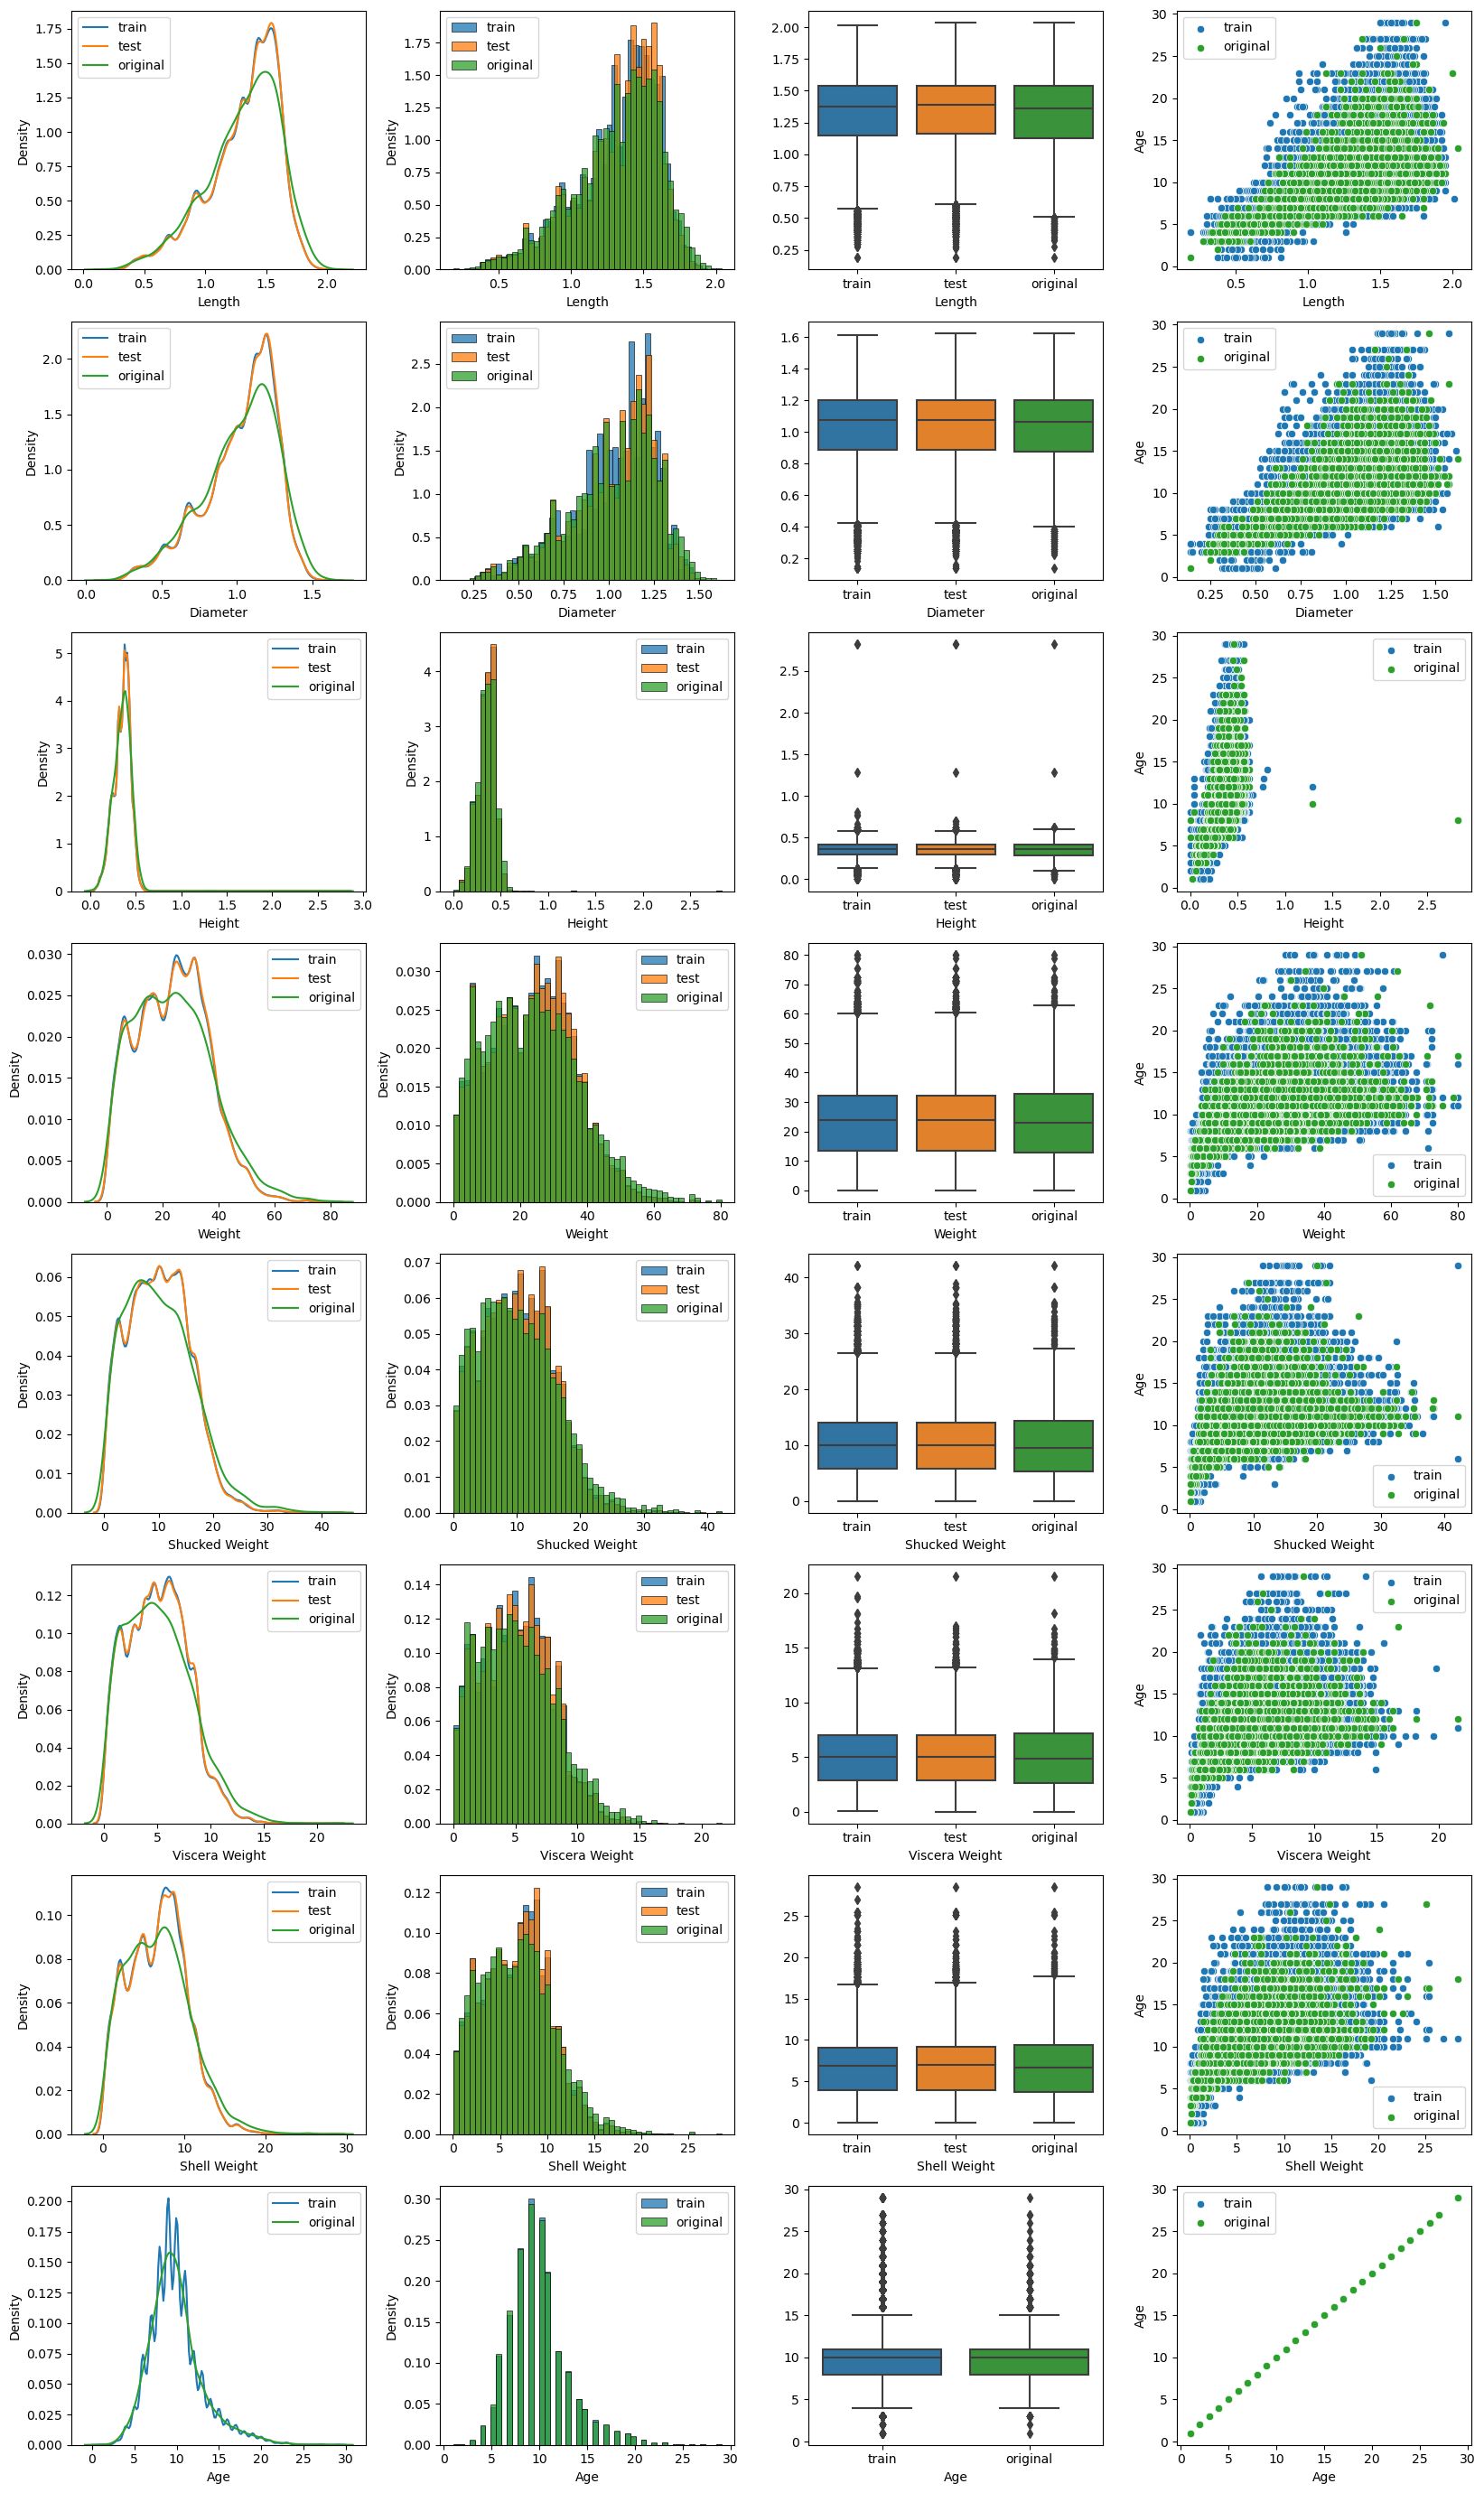

In [15]:
fig, axes = plt.subplots(nrows=len(df_train.columns) - 1, ncols=4, figsize=(20, 35))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int, palette=sns.color_palette("tab10")) -> None:
    # Plot densities
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False, color=palette[e])
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50, color=palette[e])

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2], palette=palette)
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for e, cd in enumerate(data):
        df, column, label = cd
        if label != 'test':
            sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df, color=palette[e])

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[col]):
        if col != 'Age':
            graph_numerical_feature([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], 'Age', i)
            i += 4
graph_numerical_feature([(df_train, 'Age', 'train'), (df_og, 'Age', 'original')], 'Age', i, palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
plt.show()

##### The original data closely follows the distribution of our given synthetic data.

In [16]:
age_range = df_train['Age'].max() - df_train['Age'].min()
age_uniqe_values = df_train['Age'].nunique()
print(f'Age Range: {age_range} Uniq Ages: {age_uniqe_values}')

Age Range: 28 Uniq Ages: 28


##### The age density grpah needs to have its bin count adjusted

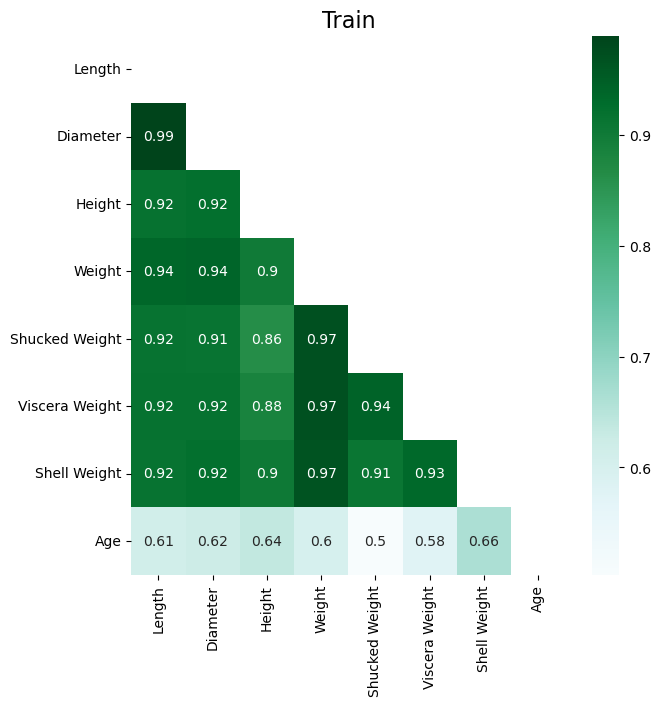

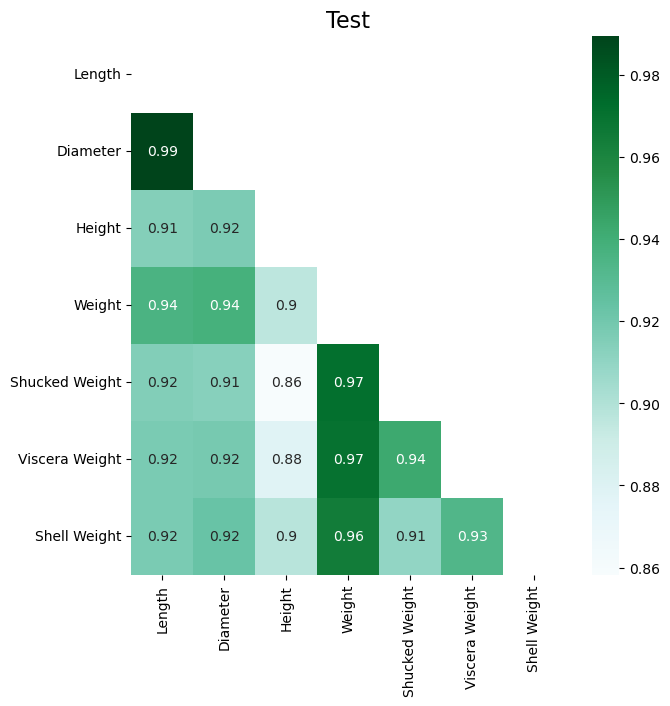

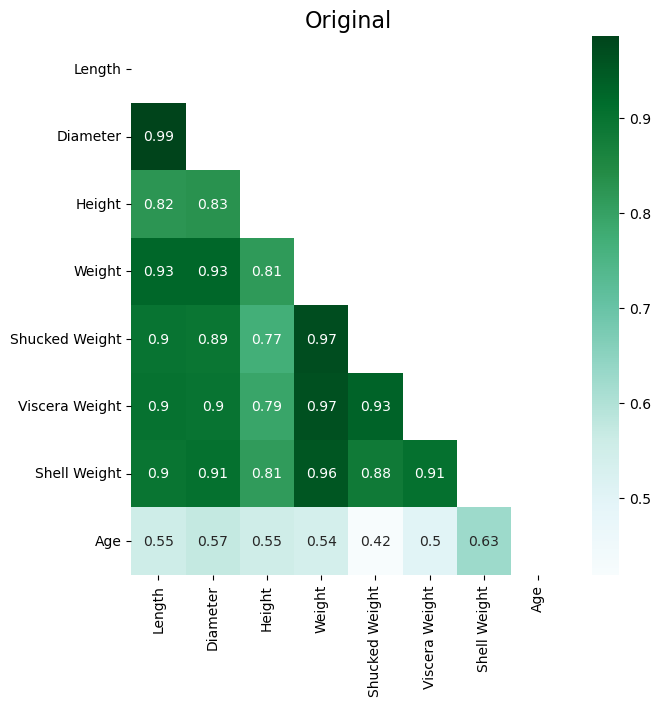

In [17]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(7, 7))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='BuGn', annot=True, mask=mask)
    plt.title(title, fontsize=16)
    plt.yticks(rotation=360) # I don't know why rotating by 360 as an effect of 90 degree ration, 90-degree rotation had no effect
    plt.show()

show_feature_correlation(df_train, "Train")
show_feature_correlation(df_test, "Test")
show_feature_correlation(df_og, "Original")

Diameter and Length are perfectly correlated and Weight, Shell Weigth, Viscera Weight and Shucked Weight are almost perfectly correlated.

When two or more features in a dataset are highly correlated, they can provide redundant information to the model, which does not add any additional information over the other features. This redundancy can cause instability in the model and lead to biased predictions.

Decision tree-based algorithms, such as Random Forest, LGBM and XGBoost, choose a subset of features for consideration at each node. This situation can lead to a bias towards the correlated features, which may negatively impact the model's performance.

# Data Prep

In [18]:
numerical_columns = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']
numerical_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight',]
categorical_columns = ['Sex']
target = 'Age'

In [19]:
def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

In [20]:
df_train: pd.DataFrame = pd.concat([df_train, df_og])
df_train.reset_index(inplace=True, drop=True)

In [21]:
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

In [22]:
to_drop = ['Diameter']
df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [23]:
df_train, df_holdout = train_test_split(df_train, test_size=0.2, random_state=1)

# Train

## Hypermarket search

In [24]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        #'num_leaves': trial.suggest_int('num_leaves', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val.ravel())], verbose=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-30 16:56:10,352] A new study created in memory with name: no-name-6850fc74-e91d-4997-9493-9eb5e3df36d1
[I 2023-05-30 16:56:54,141] Trial 0 finished with value: 1.4839215294351213 and parameters: {'n_estimators': 4793, 'max_depth': 15, 'learning_rate': 0.07965345153865143, 'min_child_samples': 5, 'reg_alpha': 1.7986637491921365, 'reg_lambda': 4.6245486188302145, 'force_col_wise': True}. Best is trial 0 with value: 1.4839215294351213.
[I 2023-05-30 16:57:43,142] Trial 1 finished with value: 1.4219582495866068 and parameters: {'n_estimators': 4875, 'max_depth': 63, 'learning_rate': 0.01389419362299364, 'min_child_samples': 3, 'reg_alpha': 9.848374563982823, 'reg_lambda': 1.8096844729963613, 'force_col_wise': False}. Best is trial 1 with value: 1.4219582495866068.
[I 2023-05-30 16:58:06,360] Trial 2 finished with value: 1.4567690886759372 and parameters: {'n_estimators': 2449, 'max_depth': 25, 'learning_rate': 0.09628805579342987, 'min_child_samples': 2, 'reg_alpha': 8.847933896

Best Parameters: {'n_estimators': 2006, 'max_depth': 23, 'learning_rate': 0.012200091726029708, 'min_child_samples': 10, 'reg_alpha': 7.741022359464507, 'reg_lambda': 2.8702867065998316, 'force_col_wise': True}
Best MAE: 1.4132977208158015


In [25]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=50)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-30 17:31:51,060] A new study created in memory with name: no-name-3f1b84ce-75e6-4f2b-ae03-5bea79744233
[I 2023-05-30 17:32:19,742] Trial 0 finished with value: 1.3725796600933344 and parameters: {'depth': 7, 'learning_rate': 0.033430408845062924, 'l2_leaf_reg': 0.2121854922405606, 'random_strength': 0.19784254677313073, 'bagging_temperature': 0.6041138514956779, 'grow_policy': 'Lossguide', 'iterations': 1386}. Best is trial 0 with value: 1.3725796600933344.
[I 2023-05-30 17:32:42,645] Trial 1 finished with value: 1.3744189518166223 and parameters: {'depth': 4, 'learning_rate': 0.0431887893395935, 'l2_leaf_reg': 0.6490679055350101, 'random_strength': 0.630831823201054, 'bagging_temperature': 0.7700417456141647, 'grow_policy': 'SymmetricTree', 'iterations': 3028}. Best is trial 0 with value: 1.3725796600933344.
[I 2023-05-30 17:32:49,672] Trial 2 finished with value: 1.3788570819879666 and parameters: {'depth': 10, 'learning_rate': 0.19394643190737165, 'l2_leaf_reg': 0.1474946

Best Parameters: {'depth': 10, 'learning_rate': 0.01795864296516127, 'l2_leaf_reg': 0.7460521058039424, 'random_strength': 0.017526746527665546, 'bagging_temperature': 0.1984178672792779, 'grow_policy': 'Lossguide', 'iterations': 3528}
Best MAE: 1.3695310048523994


In [26]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',#'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.00, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 2.0),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('Age', axis=1)
    y = df_train['Age']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_xgboost.best_params
best_mae = study_xgboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-30 18:04:09,508] A new study created in memory with name: no-name-0fc7ba3f-42bc-4d1c-befa-74be63e92048
[I 2023-05-30 18:04:10,388] Trial 0 finished with value: 2.3746914597657276 and parameters: {'n_estimators': 958, 'max_depth': 11, 'learning_rate': 0.020427441060329246, 'min_child_weight': 6.067591538012993, 'gamma': 0.14818379294535466, 'subsample': 0.9546392627716157, 'colsample_bytree': 0.8166423609539797, 'reg_alpha': 4.632869331671724, 'reg_lambda': 6.669163872928045, 'eta': 0.19782197747842323, 'huber_slope': 1.5079269886081923}. Best is trial 0 with value: 2.3746914597657276.
[I 2023-05-30 18:04:11,265] Trial 1 finished with value: 2.2025978434258864 and parameters: {'n_estimators': 1670, 'max_depth': 15, 'learning_rate': 0.012530907876325686, 'min_child_weight': 1.679619756150701, 'gamma': 0.07649599573546373, 'subsample': 0.5653738262147516, 'colsample_bytree': 0.6437741820710222, 'reg_alpha': 1.1524934245656882, 'reg_lambda': 8.468364952022183, 'eta': 0.740660310

Best Parameters: {'n_estimators': 4520, 'max_depth': 11, 'learning_rate': 0.07564123295552887, 'min_child_weight': 8.769265973163723, 'gamma': 0.8351772672997373, 'subsample': 0.9308317951816667, 'colsample_bytree': 0.8413383863931512, 'reg_alpha': 3.043027621457837, 'reg_lambda': 8.070131988115108, 'eta': 0.6489685921655559, 'huber_slope': 1.9988768892677347}
Best MAE: 1.775113748496579


## Train models with found hyperspaces

In [27]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study_lgbm.best_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**study_catboost.best_params)
        elif model_type == 'XGBoost':
            self.model = xgb.XGBRegressor(**study_xgboost.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['CatBoost']:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], early_stopping_rounds=100, verbose=False)
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [28]:
def train(model_type):
    X = df_train.drop(['Age'], axis=1)
    y = df_train['Age']
    SKFs = KFold(n_splits=10, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('Age', axis=1)
        y_train = train_dataframe['Age']
        X_dev = dev_dataframe.drop('Age', axis=1)
        y_dev = dev_dataframe['Age']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [29]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost']
supported_models = ['LightGBM', 'CatBoost']

In [30]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

-------------------- LightGBM -------------------- 
Fold 0 loss: 1.3913754390690036
Fold 1 loss: 1.414107995404882
Fold 2 loss: 1.3636449114568423
Fold 3 loss: 1.391389365438434
Fold 4 loss: 1.4026574649624541
Fold 5 loss: 1.396526497998122
Fold 6 loss: 1.4133391635497805
Fold 7 loss: 1.4161180137443767
Fold 8 loss: 1.4065251599135067
Fold 9 loss: 1.4298477130370073
Mean loss: 1.402553172457441
-------------------- CatBoost -------------------- 
Fold 0 loss: 1.3902827143393826
Fold 1 loss: 1.4132768172026047
Fold 2 loss: 1.367727794165401
Fold 3 loss: 1.3911921434508252
Fold 4 loss: 1.4036576394187472
Fold 5 loss: 1.3969966631575739
Fold 6 loss: 1.4141799271647497
Fold 7 loss: 1.4184033604732478
Fold 8 loss: 1.4095717132753085
Fold 9 loss: 1.4332129609697688
Mean loss: 1.403850173361761


# Assembly

In [31]:
df_assembly = pd.DataFrame({})

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

for model_name in supported_models:
    X = df_holdout.drop(target, axis=1)
    df_assembly[model_name] = make_model_predictions(model_name, X)

## Simple weighted assembly

In [32]:
def eval_assembly_on_validation(weights):
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_assembly[x] * weights[model_id]

    return mean_absolute_error(df_holdout[target], prediction)

In [33]:
# Set initial weights
model_weights = np.array([1/len(df_assembly.columns.values) for i in range(len(df_assembly.columns.values))])
# Define the optimization bounds
bounds = [(0, 1.0)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

0.9689267110079525
1.0


In [34]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(df_assembly.columns.values)):
    df_optimal_model_weights['model_name'].append(df_assembly.columns.values[i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {df_assembly.columns.values[i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.603 LightGBM
0.397 CatBoost


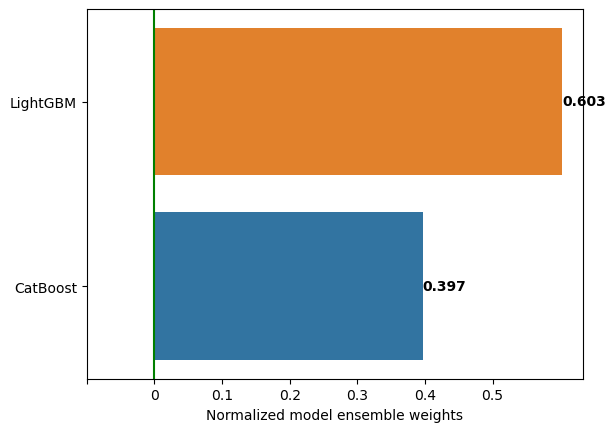

In [35]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights, palette=sns.color_palette("tab10"))
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='left', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

In [36]:
def make_weighted_assembly_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    prediction = 0
    for model_id, x in enumerate(df_assembly.columns.values):
        prediction += df_tmp[x] * optimal_model_weights[model_id]
    return prediction

In [37]:
print(mean_absolute_error(df_holdout[target], make_weighted_assembly_predictions(df_holdout.drop(target, axis=1))))

1.3943956468576295


## Stacked assembly

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_assembly, df_holdout[target], test_size=0.2, random_state=1)
lgbm_blender_model = lgb.LGBMRegressor()
lgbm_blender_model.fit(X_train, y_train, eval_set=[(X_test, y_test.ravel())], verbose=False)
print(mean_absolute_error(y_test, lgbm_blender_model.predict(X_test)))

1.408332304869904


In [39]:
def make_stacked_predictions(X):
    df_tmp = pd.DataFrame({})
    for model_name in supported_models:
        df_tmp[model_name] = make_model_predictions(model_name, X)
    return lgbm_blender_model.predict(df_tmp)

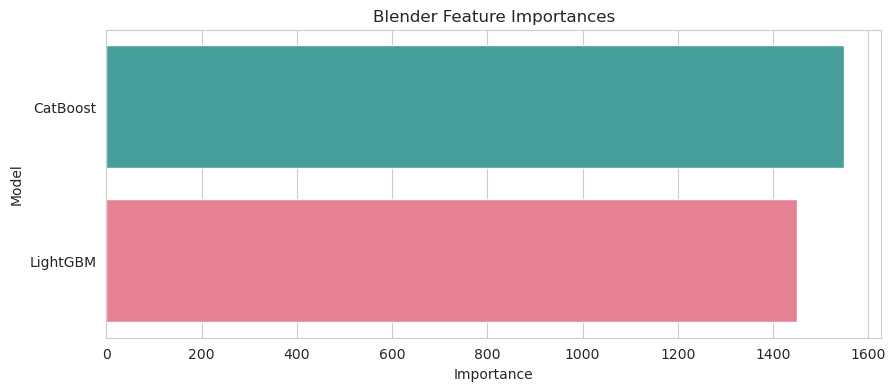

In [40]:
df_importance = pd.DataFrame({'feature': df_assembly.columns.values, 'importance': lgbm_blender_model.feature_importances_})
df_importance = df_importance.sort_values('importance', ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Blender Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Model')
plt.show()

# Models evaluation

In [41]:
performance_data = {'model_name': [], 'loss_og': [], 'loss_given': [], 'loss_joined': []}

def make_model_predictions(model_name, X):
    prediction = 0
    for pipeline in train_results[f'{model_name}_pipelines']:
        prediction += pipeline.predict(X)
    return prediction / float(len(train_results[f'{model_name}_pipelines']))

df_holdout_og = df_holdout[df_holdout.index >= 74051]
df_holdout_given = df_holdout[df_holdout.index < 74051]
X_og = df_holdout_og.drop(target, axis=1)
y_og = df_holdout_og[target]
X_given = df_holdout_given.drop(target, axis=1)
y_given = df_holdout_given[target]
X_joined = df_holdout.drop(target, axis=1)
y_joined = df_holdout[target]

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['loss_og'].append(mean_absolute_error(y_og, make_model_predictions(model_name, X_og)))
    performance_data['loss_given'].append(mean_absolute_error(y_given, make_model_predictions(model_name, X_given)))
    performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_model_predictions(model_name, X_joined)))

performance_data['model_name'].append('LGBM Stacking')
performance_data['loss_og'].append(mean_absolute_error(y_og, make_stacked_predictions(X_og)))
performance_data['loss_given'].append(mean_absolute_error(y_given, make_stacked_predictions(X_given)))
performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_stacked_predictions(X_joined)))

performance_data['model_name'].append('Weighted Assembly')
performance_data['loss_og'].append(mean_absolute_error(y_og, make_weighted_assembly_predictions(X_og)))
performance_data['loss_given'].append(mean_absolute_error(y_given, make_weighted_assembly_predictions(X_given)))
performance_data['loss_joined'].append(mean_absolute_error(y_joined, make_weighted_assembly_predictions(X_joined)))

performance_data = pd.DataFrame(performance_data)

In [42]:
def graph_model_performance(loss: str, title:str, ax):
    sns.barplot(x=loss, y='model_name', data=performance_data, ax=ax, palette=palette_reversed)
    for i, v in enumerate(performance_data[loss]):
        ax.text(v - 0.003, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    ax.set(ylabel=None)
    ax.set(xlabel="MAE")
    ax.set_title(title)

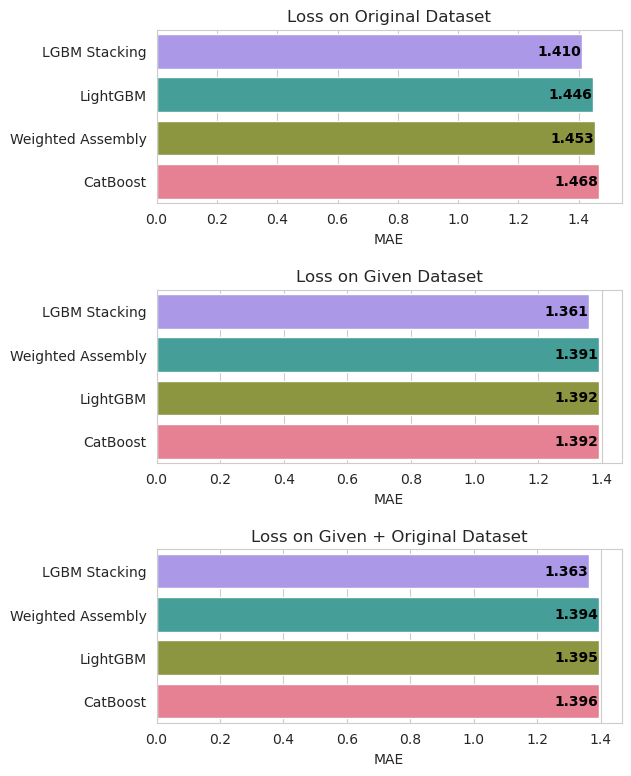

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]

performance_data.sort_values('loss_og', ascending=True, inplace=True)
graph_model_performance('loss_og', 'Loss on Original Dataset', axes[0])
performance_data.sort_values('loss_given', ascending=True, inplace=True)
graph_model_performance('loss_given', 'Loss on Given Dataset', axes[1])
performance_data.sort_values('loss_joined', ascending=True, inplace=True)
graph_model_performance('loss_joined', 'Loss on Given + Original Dataset', axes[2])
plt.show()

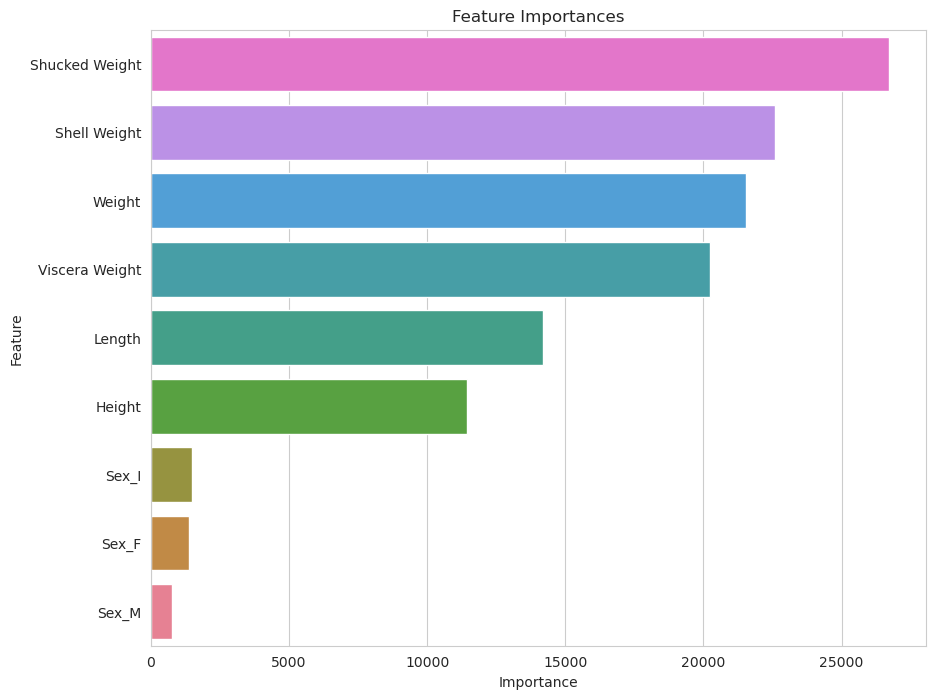

In [44]:
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('Age', axis=1).columns.values
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
df_importance = df_importance.sort_values('importance', ascending=False)


sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

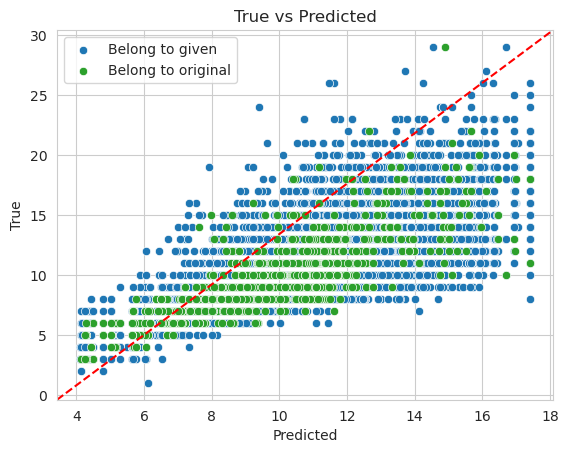

In [45]:
graph_data = {
    "data": [(X_given, y_given), (X_og, y_og)],
    "name": ['given', 'original']
}

sns.set_palette([sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])
for data, name in zip(graph_data['data'], graph_data['name']):
    y = data[1]
    y_predicted = make_stacked_predictions(data[0])
    data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
    sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
plt.title("True vs Predicted")
plt.legend()
plt.show()

# Make predictions

In [46]:
predictions = make_weighted_assembly_predictions(df_test)

In [47]:
df_sub = pd.DataFrame({'id': df_test.index, 'Age': predictions})
df_sub['Age'] = df_sub['Age'].round().astype(int)

In [48]:
df_sub

,id,Age
0,74051,7
1,74052,8
2,74053,11
3,74054,9
4,74055,8
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,10


In [49]:
df_sub.to_csv("submission.csv", index=False)